# Problema 3

In [54]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%run lib.ipynb # cargamos nuestras definiciones anteriores de integradores, y un truco de matplotlib
%matplotlib inline

Comienzo por programar las siguientes funciones:  

    - La ecuacion de movimiento; dada la posicion y la velocidad, regresa la velocidad y la fuerza
    - El modelo de friccion; dada la velocida da la fuerza de resistencia contra el aire
    - La geometria de la rampa; con el angulo, para cada valor de x regresa la altura (y) de la rampa

In [2]:
def ec_mov(r_v, t, fric = 0.0, g = 9.81, m = 1.):
    """
    r_v debe contener x, y, vx, vy
    Ecuacion de movimiento para una particula 
        - en un campo gravitacionl uniforme en direccion y
        - con friccion
    Si fric = 0.0 = g, tenemos la particula libre.
    """
    u = sqrt(r_v[2]**2 + r_v[3]**2)
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0.:
        dvx = 0.
        dvy = -g/m
    else:
        dvx = -fric([r_v[2], r_v[3]])[0]
        dvy = -g/m -fric([r_v[2], r_v[3]])[1]
    return array([dx,dy,dvx,dvy])
def fricV2(v, gamma = 0.05):
    """
    Modelo de friccion proporcional al cuadrado de la velocidad.
    """
    V = norm(v)
    f_x = gamma*V*v[0]
    f_y = gamma*V*v[1]
    return array([f_x,f_y])
def rampa(x,alpha):
    """
    Funcion para dar la y de la rampa en funcion de x y del angulo alpha de inclinacion.
    Supone que la rampa es simetrica y que su minimo esta en el origen.
    """
    return np.array(np.abs(x)*np.tan(alpha),np.float16)

Ahora, hacemos tres funciones que encuentren puntos apropiados de rebote y que tomando en cuenta la geometria del problema, modifiquen las velocidades segun lo esperado de un choque elástico con la barrera.

Hay una funcion para el rebote con el techo, una para las paredes, y otra para ambas caras de la rampa.

In [3]:
def rebote_rampa(r_v_i,mi_dt,alpha,tol=1e-2,**kwargs):
    dt_busqueda = mi_dt/2
    y0 = r_v_i
    t,sol = int_rk4(ec_mov,y0,[0,dt_busqueda],**kwargs)
    y1 = sol[-1,:]
    while abs(y0[1]-rampa(y0[0],alpha)) > tol:
        if y1[1] > rampa(y1[0],alpha):
            reinicio = y1
        else:
            reinicio = y0
        dt_busqueda = dt_busqueda/2
        t,sol = int_rk4(ec_mov,reinicio,[0,dt_busqueda],**kwargs)
        y0 = reinicio
        y1 = sol[-1,:]  
    # rebote radial
    V = norm(y0[2:])
    alpha = np.arctan((y0[1])/(y0[0]))
    # se puede reducir a dos casos, pero lo dejo ahora por claridad
    if   y0[3]>0 and y0[2]<0:
        gamma = np.pi+np.arctan((y0[3])/(y0[2])) if not np.isclose(0.0,y0[2]) else -np.pi/2
    elif y0[3]<0 and y0[2]<0:
        gamma = np.pi+np.arctan((y0[3])/(y0[2])) if not np.isclose(0.0,y0[2]) else -np.pi/2
    elif y0[3]<0 and y0[2]>0:
        gamma = np.arctan((y0[3])/(y0[2])) if not np.isclose(0.0,y0[2]) else -np.pi/2              
    else:
        gamma = np.arctan((y0[3])/(y0[2])) if not np.isclose(0.0,y0[2]) else -np.pi/2   
    y0[3] = V*np.sin(2*alpha-gamma)
    y0[2] = V*np.cos(2*alpha-gamma)   
    return y0
def rebote_techo(r_v_i,mi_dt,roof,tol=1e-2,**kwargs):
    dt_busqueda = mi_dt/2
    y0 = r_v_i
    t,sol = int_rk4(ec_mov,y0,[0,dt_busqueda],**kwargs)
    y1 = sol[-1,:]  
    while abs(y0[1]-roof) > tol:
        if y1[1] > roof:
            reinicio = y0
        else:
            reinicio = y1
        dt_busqueda = dt_busqueda/2
        t,sol = int_rk4(ec_mov,reinicio,[0,dt_busqueda],**kwargs)
        y0 = reinicio
        y1 = sol[-1,:]  
    # rebote vertical
    y0[3] *= -1
    return y0
def rebote_pared(r_v_i,mi_dt,wall,tol=1e-2,**kwargs):
    dt_busqueda = mi_dt/2
    y0 = r_v_i
    t,sol = int_rk4(ec_mov,y0,[0,dt_busqueda],**kwargs)
    y1 = sol[-1,:]
    while abs(wall-abs(y0[0])) > tol:
        if abs(y1[0]) < wall:
            reinicio = y1
        else:
            reinicio = y0   
        dt_busqueda = dt_busqueda/2
        t,sol = int_rk4(ec_mov,reinicio,[0,dt_busqueda],**kwargs)
        y0 = reinicio
        y1 = sol[-1,:] 
    # rebote horizontal
    y0[2] *= -1
    return y0

In [30]:
alpha = np.pi*np.array([1.0/6,0.1])
disparo = [1,2,3]
sims = {}

In [73]:
mi_dt=0.005
V = 3.0
L,d = 10.0,3.0

for a in alpha:
    wall, roof = L/2, d+rampa(L/2,a)
    fric, grav = 0.0, 9.81
    
    for n in disparo:
        inicio = np.array([ -L/3 , rampa(L/3,a)+0.1 , V*cos(n*a) , V*sin(n*a) ])
        print inicio
        trayectoria=empty((10000,len(inicio)))
        trayectoria[0,:]=array(inicio)

        rebotes, i = 0, 0
        while rebotes < 23 and i < 10000:
            t,sol = int_rk4(ec_mov,trayectoria[i,:],[0,mi_dt],fric=fric,g=grav)
            y = sol[-1,:]
            # condicion piso
            yr = rampa(y[0],a)
            if y[1] < yr: 
                y = rebote_rampa(trayectoria[i,:],mi_dt,a   ,tol=1e-2,fric=fric,g=grav)
                rebotes += 1
            # condicion techo
            elif y[1] > roof:
                y = rebote_techo(trayectoria[i,:],mi_dt,roof,tol=1e-2,fric=fric,g=grav)
                rebotes += 1
            # condicion paredes
            if abs(y[0]) > wall :
                y = rebote_pared(trayectoria[i,:],mi_dt,wall,tol=1e-2,fric=fric,g=grav)
                rebotes += 1
            trayectoria[i+1,:] = y
            i += 1
        print i, " pasos"
        sims[(a,n)] = trayectoria[:i]    

[-3.23333333  2.02480469  2.59807621  1.5       ]
2955  pasos
[-3.23333333  2.02480469  1.5         2.59807621]
3934  pasos
[ -3.23333333e+00   2.02480469e+00   1.83697020e-16   3.00000000e+00]
3301  pasos
[-3.23333333  1.18300781  2.85316955  0.92705098]
3102  pasos
[-3.23333333  1.18300781  2.42705098  1.76335576]
3069  pasos
[-3.23333333  1.18300781  1.76335576  2.42705098]
2430  pasos


[-3.23333333  2.02480469  2.59807621  1.5       ]
[-3.23333333  2.02480469  1.5         2.59807621]
[ -3.23333333e+00   2.02480469e+00   1.83697020e-16   3.00000000e+00]
[-3.23333333  1.18300781  2.85316955  0.92705098]
[-3.23333333  1.18300781  2.42705098  1.76335576]
[-3.23333333  1.18300781  1.76335576  2.42705098]


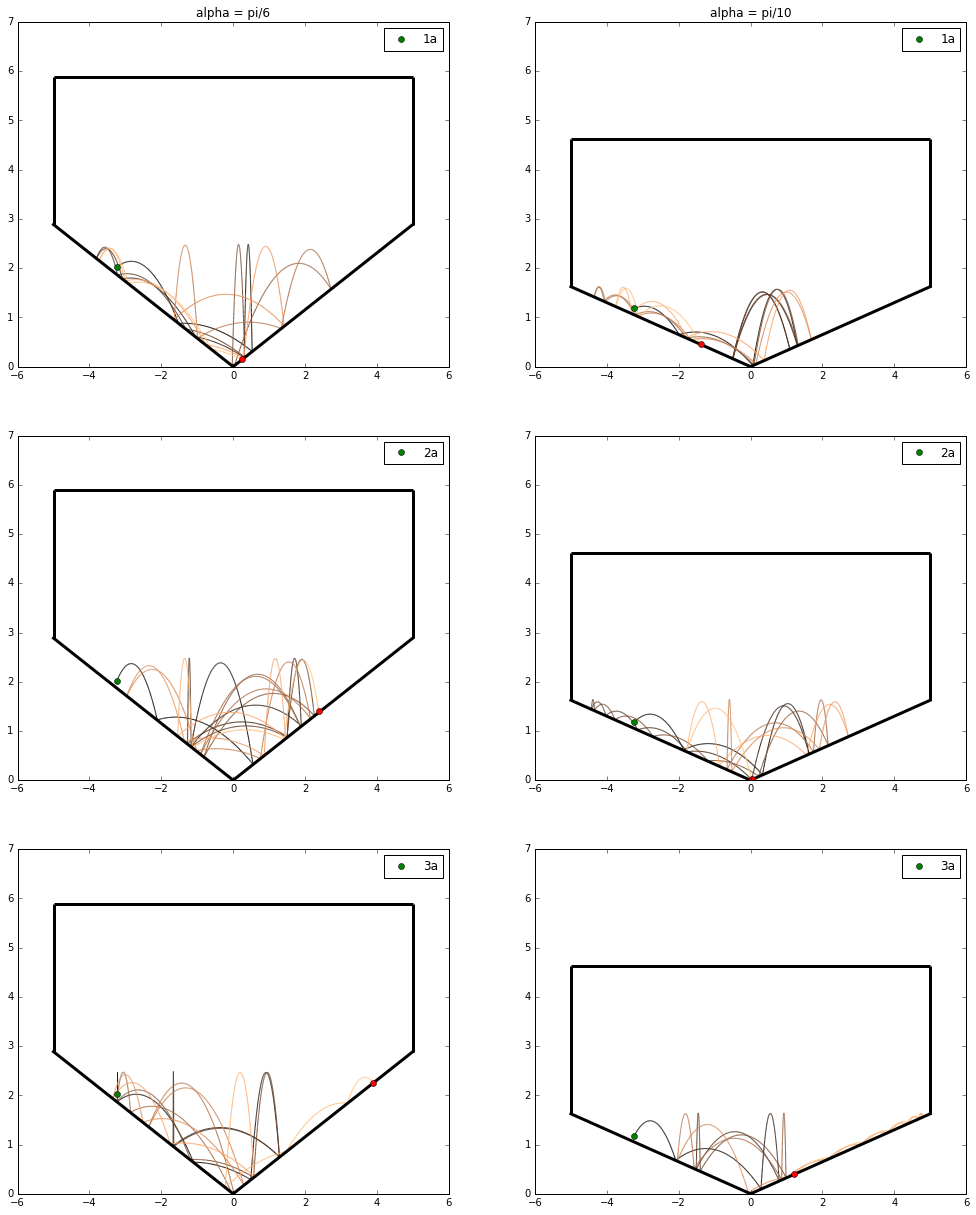

In [74]:
fig = plt.figure(figsize=(17,21))
x = np.linspace(-L/2,L/2,800)
for j in xrange(alpha.shape[0]):
    a = alpha[j]
    title = "alpha = pi/6" if j==0 else "alpha = pi/10"
    for n in disparo:
        trayectoria = sims[(a,n)]
        print trayectoria[0,:]
        label = "{}a".format(n)
        title = title if n==1 else ""
        
        r = 2*n-1 if j==0 else 2*n
        ax = fig.add_subplot(3,2,r)
        ax.plot(x,rampa(x,a),color="k",lw=3)
        ax.hlines(d+rampa(L/2,a),-L/2,L/2,color="k",lw=3)
        ax.vlines([-L/2,L/2],rampa(L/2,a),rampa(L/2,a)+d,color="k",lw=3)

        colorline(trayectoria[:,0],trayectoria[:,1],cmap='copper', linewidth=1)
        ax.plot(trayectoria[+0,0],trayectoria[ 0,1],'o',c="g", label=label)
        ax.plot(trayectoria[-1,0],trayectoria[-1,1],'o',c="r")

        ax.legend(numpoints=1,loc="best")
        ax.set_title(title)
        ax.set_ylim(0,7); ax.set_xlim(-6,6);